This notebook is part of the deepcell-tf documentation: https://deepcell.readthedocs.io/.

# Training a cell tracking model

Implementation of: [Accurate cell tracking and lineage construction in live-cell imaging experiments with deep learning](https://www.biorxiv.org/content/10.1101/803205v2)


In [1]:
%load_ext autoreload
%autoreload 2

import os
import wandb
import deepcell

import tensorflow as tf
import numpy as np

## Set up file path constants

In [2]:
import errno

ROOT_DIR = '/data'  # TODO: Change this! Usually a mounted volume

MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models'))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs'))
DATA_DIR = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))
OUTPUT_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'nuc_tracking'))

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR, OUTPUT_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

## Load the data

### Download data from deepcell.datasets

`deepcell.datasets` provides access to a set of annotated live-cell imaging datasets which can be used for training cell segmentation and tracking models. All dataset objects share the `load_data()` method, which allows the user to specify the name of the file (`path`), the fraction of data reserved for testing (`test_size`) and a `seed`, which is used to generate the random train-test split. Metadata associated with the dataset can be accessed through the `metadata` attribute.

Tracked data are stored as `.trks` files. These files include images and lineage data in np.arrays. To manipulate `.trks` files, use `deepcell.utils.tracking_utils.load_trks` and `deepcell.utils.tracking_utils.save_trks`.

In [3]:
# Download sample tracking data (saves to ~/.keras/datasets)
# from deepcell.datasets.tracked import hek293

# filename = 'sample_tracking.trks'
# (X_train, y_train), (X_test, y_test) = hek293.load_tracked_data(filename)

1344610304/1344604160 [==============================] - 52s 0us/step


In [3]:
# Load and view stats on this file
from deepcell.utils.tracking_utils import trks_stats, load_trks

filename = 'train.trks'
path = os.path.join('../trk_data/',filename)

# path = os.path.join(DATA_DIR, filename)
# trks_stats(path)
trks_data = load_trks(path)

In [6]:
import random 
seed = 42
def get_division_dict(trks_data):

    movie_division_cnt = {}
    for i, movie in enumerate(trks_data['lineages']):
        daughters_cnt = 0
        for k, v in movie.items():
            # print(k,'space' ,len(v['daughters']))
            daughters_cnt += len(v['daughters'])

        movie_division_cnt[i] = daughters_cnt

    return movie_division_cnt
    
def partition(list_in, n):
    random.seed(seed)
    random.shuffle(list_in)
    return [list_in[i::n] for i in range(n)]

def partition_by_size(trks_data):

    movie_division_cnt = get_division_dict(trks_data)
    
    ds = partition(list(movie_division_cnt.keys()), 10)

    for d in ds:
        print(f'partition size {len(d)}', f'mean number of divisions {np.mean([movie_division_cnt[i] for i in d])}')

    data_growing = []
    for i, d in enumerate(ds):
        if i == 0:
            data_growing.append(d)
        else:
            data_growing.append(data_growing[i-1] + d)
        # print(len(data_growing[i]))
    return data_growing

In [7]:
# data_growing = partition_by_size(trks_data)

partition size 22 mean number of divisions 10.681818181818182
partition size 22 mean number of divisions 6.7272727272727275
partition size 22 mean number of divisions 4.2272727272727275
partition size 22 mean number of divisions 3.9545454545454546
partition size 21 mean number of divisions 4.285714285714286
partition size 21 mean number of divisions 4.714285714285714
partition size 21 mean number of divisions 8.19047619047619
partition size 21 mean number of divisions 4.0476190476190474
partition size 21 mean number of divisions 5.9523809523809526
partition size 21 mean number of divisions 4.619047619047619


In [8]:
# dataset_sizes = os.path.abspath(os.path.join(ROOT_DIR, 'dataset_idxs_dvc.npy'))
# np.save(dataset_sizes, data_growing)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [4]:
dataset_sizes = os.path.abspath(os.path.join(ROOT_DIR, 'dataset_idxs_dvc.npy'))
dataset_indicies = np.load(dataset_sizes, allow_pickle=True).tolist()

In [12]:
len(dataset_indicies[0])

22

In [15]:
i =0
new_data = {}
new_data['lineages'] = list(np.array(trks_data['lineages'])[dataset_indicies[i]])
new_data['X'] = trks_data['X'][dataset_indicies[i],...]
new_data['y'] = trks_data['y'][dataset_indicies[i],...]

ds_size = len(dataset_indicies[i])


print()
print('data idx', i, 'size', ds_size)
print()

all_tracks = Track(tracked_data=new_data)
track_info = concat_tracks([all_tracks])


data idx 0 size 22



100%|██████████| 22/22 [00:41<00:00,  1.89s/it]


## Prepare the data

To facilitate training, we transform each movie's image and lineage data into a `Track` object.
`Tracks` help to encapsulate all of the feature creation from the movie, including:

* Appearances: `(num_frames, num_objects, 32, 32, 1)`
* Morphologies: `(num_frames, num_objects, 32, 32, 3)`
* Centroids: `(num_frames, num_objects, 2)`
* Normalized Adjacency Matrix: `(num_frames, num_objects, num_objects, 3)`
* Temporal Adjacency Matrix (comparing across frames): `(num_frames - 1, num_objects, num_objects, 3)`

All `Track` objects are then concatenated with each other (using `concat_tracks`) resulting in a single array for each feature.

In [5]:
%%time

from deepcell.data.tracking import Track

all_tracks = Track(tracked_data=trks_data)

100%|██████████| 214/214 [07:00<00:00,  1.96s/it]


CPU times: user 53min 22s, sys: 40min 33s, total: 1h 33min 55s
Wall time: 15min 52s


In [6]:
%%time

from deepcell.data.tracking import concat_tracks

track_info = concat_tracks([all_tracks])
for k, v in track_info.items():
    print(k, v.shape)

appearances (214, 71, 168, 32, 32, 1)
centroids (214, 71, 168, 2)
morphologies (214, 71, 168, 3)
adj_matrices (214, 71, 168, 168)
norm_adj_matrices (214, 71, 168, 168)
temporal_adj_matrices (214, 70, 168, 168, 3)
CPU times: user 3.42 s, sys: 4.86 s, total: 8.28 s
Wall time: 8.27 s


## Set up training parameters

In [18]:
seed = 1   # random seed for training/validation data split
batch_size = 4
track_length = 8  # only train on 8 frames at once
val_size = .20  # % of data saved as validation
test_size = .1  # % of data held out as a test set
n_epochs = 12  # number of training epochs

steps_per_epoch = 1000
validation_steps = 200

# find maximum number of cells in any frame
max_cells = track_info['appearances'].shape[2]

n_layers = 1  # number of graph convolutions
graph_layer = 'se2c'  # type of graph convolution layer

translation_range = 512 #X_train.shape[-2]

model_name = 'graph_tracking_model_seed{}'.format(seed)
model_path = os.path.join(MODEL_DIR, model_name)

## Create Tracking Dataset object

We then assemble `Tracks` as specified into a Tracking `Dataset` that is used during training

In [19]:
from deepcell.data.tracking import prepare_dataset


train_data, val_data, test_data = prepare_dataset(
    track_info,
    rotation_range=180,
    translation_range=translation_range,
    seed=seed,
    val_size=val_size,
    test_size=test_size,
    batch_size=batch_size,
    track_length=track_length)

## Instantiate and Compile the Model
The goal is to predict the adjacency matrix and daughter adjacency matrix by attending over the edges provided by the spatiotemporal adjacency matrix (SAM). The SAM is constructed by linking cells that are in temporal or spatial proximity.

In [20]:
from deepcell.model_zoo.tracking import GNNTrackingModel

tm = GNNTrackingModel(max_cells=max_cells, n_layers=n_layers, graph_layer=graph_layer)

Before a model can be trained, it must be compiled with the chosen optimizer, loss function, and metrics.

This model uses padded data which must be flattened and filtered out before calling our metrics and loss.

In [21]:
def filter_and_flatten(y_true, y_pred):
    n_classes = tf.shape(y_true)[-1]
    new_shape = [-1, n_classes]
    y_true = tf.reshape(y_true, new_shape)
    y_pred = tf.reshape(y_pred, new_shape)

    # Mask out the padded cells
    y_true_reduced = tf.reduce_sum(y_true, axis=-1)
    good_loc = tf.where(y_true_reduced == 1)[:, 0]

    y_true = tf.gather(y_true, good_loc, axis=0)
    y_pred = tf.gather(y_pred, good_loc, axis=0)
    return y_true, y_pred


class Recall(tf.keras.metrics.Recall):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true, y_pred = filter_and_flatten(y_true, y_pred)
        super(Recall, self).update_state(y_true, y_pred, sample_weight)


class Precision(tf.keras.metrics.Precision):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true, y_pred = filter_and_flatten(y_true, y_pred)
        super(Precision, self).update_state(y_true, y_pred, sample_weight)


def loss_function(y_true, y_pred):
    y_true, y_pred = filter_and_flatten(y_true, y_pred)
    return deepcell.losses.weighted_categorical_crossentropy(
        y_true, y_pred,
        n_classes=tf.shape(y_true)[-1],
        axis=-1)

In [22]:
from tensorflow_addons.optimizers import RectifiedAdam as RAdam


# Define optimizer
optimizer = RAdam(learning_rate=1e-3, clipnorm=0.001)

# Define the loss function
losses = {'temporal_adj_matrices': loss_function}

# Define metrics
metrics = [
    Recall(class_id=0, name='same_recall'),
    Recall(class_id=1, name='different_recall'),
    Recall(class_id=2, name='daughter_recall'),
    Precision(class_id=0, name='same_precision'),
    Precision(class_id=1, name='different_precision'),
    Precision(class_id=2, name='daughter_precision'),
]

In [23]:
# Compile model
tm.training_model.compile(optimizer=optimizer, loss=losses, metrics=metrics)

## Train Model and Verify Performance

Call fit on the compiled model, along with a defined set of callbacks.

In [24]:
from wandb.keras import WandbCallback

# Verify GPU count
from deepcell import train_utils
num_gpus = train_utils.count_gpus()
print('Training on {} GPUs'.format(num_gpus))

layer = graph_layer

run = wandb.init(project='cell_tracking', reinit=True)
wandb.run.name = layer+f'_datasize_{ds_size}'

wandb.log({'metrics': metrics,
            'losses': losses})

# Train the model
train_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        model_path, monitor='val_loss',
        save_best_only=True, verbose=1,
        save_weights_only=False),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7), WandbCallback()
]

loss_history = tm.training_model.fit(
    train_data,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_data,
    validation_steps=validation_steps,
    epochs=n_epochs,
    verbose=1,
    callbacks=train_callbacks)

Training on 1 GPUs


wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch 1/12
  14/1000 [..............................] - ETA: 7:48 - loss: 0.7916 - same_recall: 0.7442 - different_recall: 0.0197 - daughter_recall: 0.2340 - same_precision: 0.0137 - different_precision: 0.9879 - daughter_precision: 7.4283e-05

KeyboardInterrupt: 

Visualize the performance of the model by comparing the predicted classes of i frames in j movies

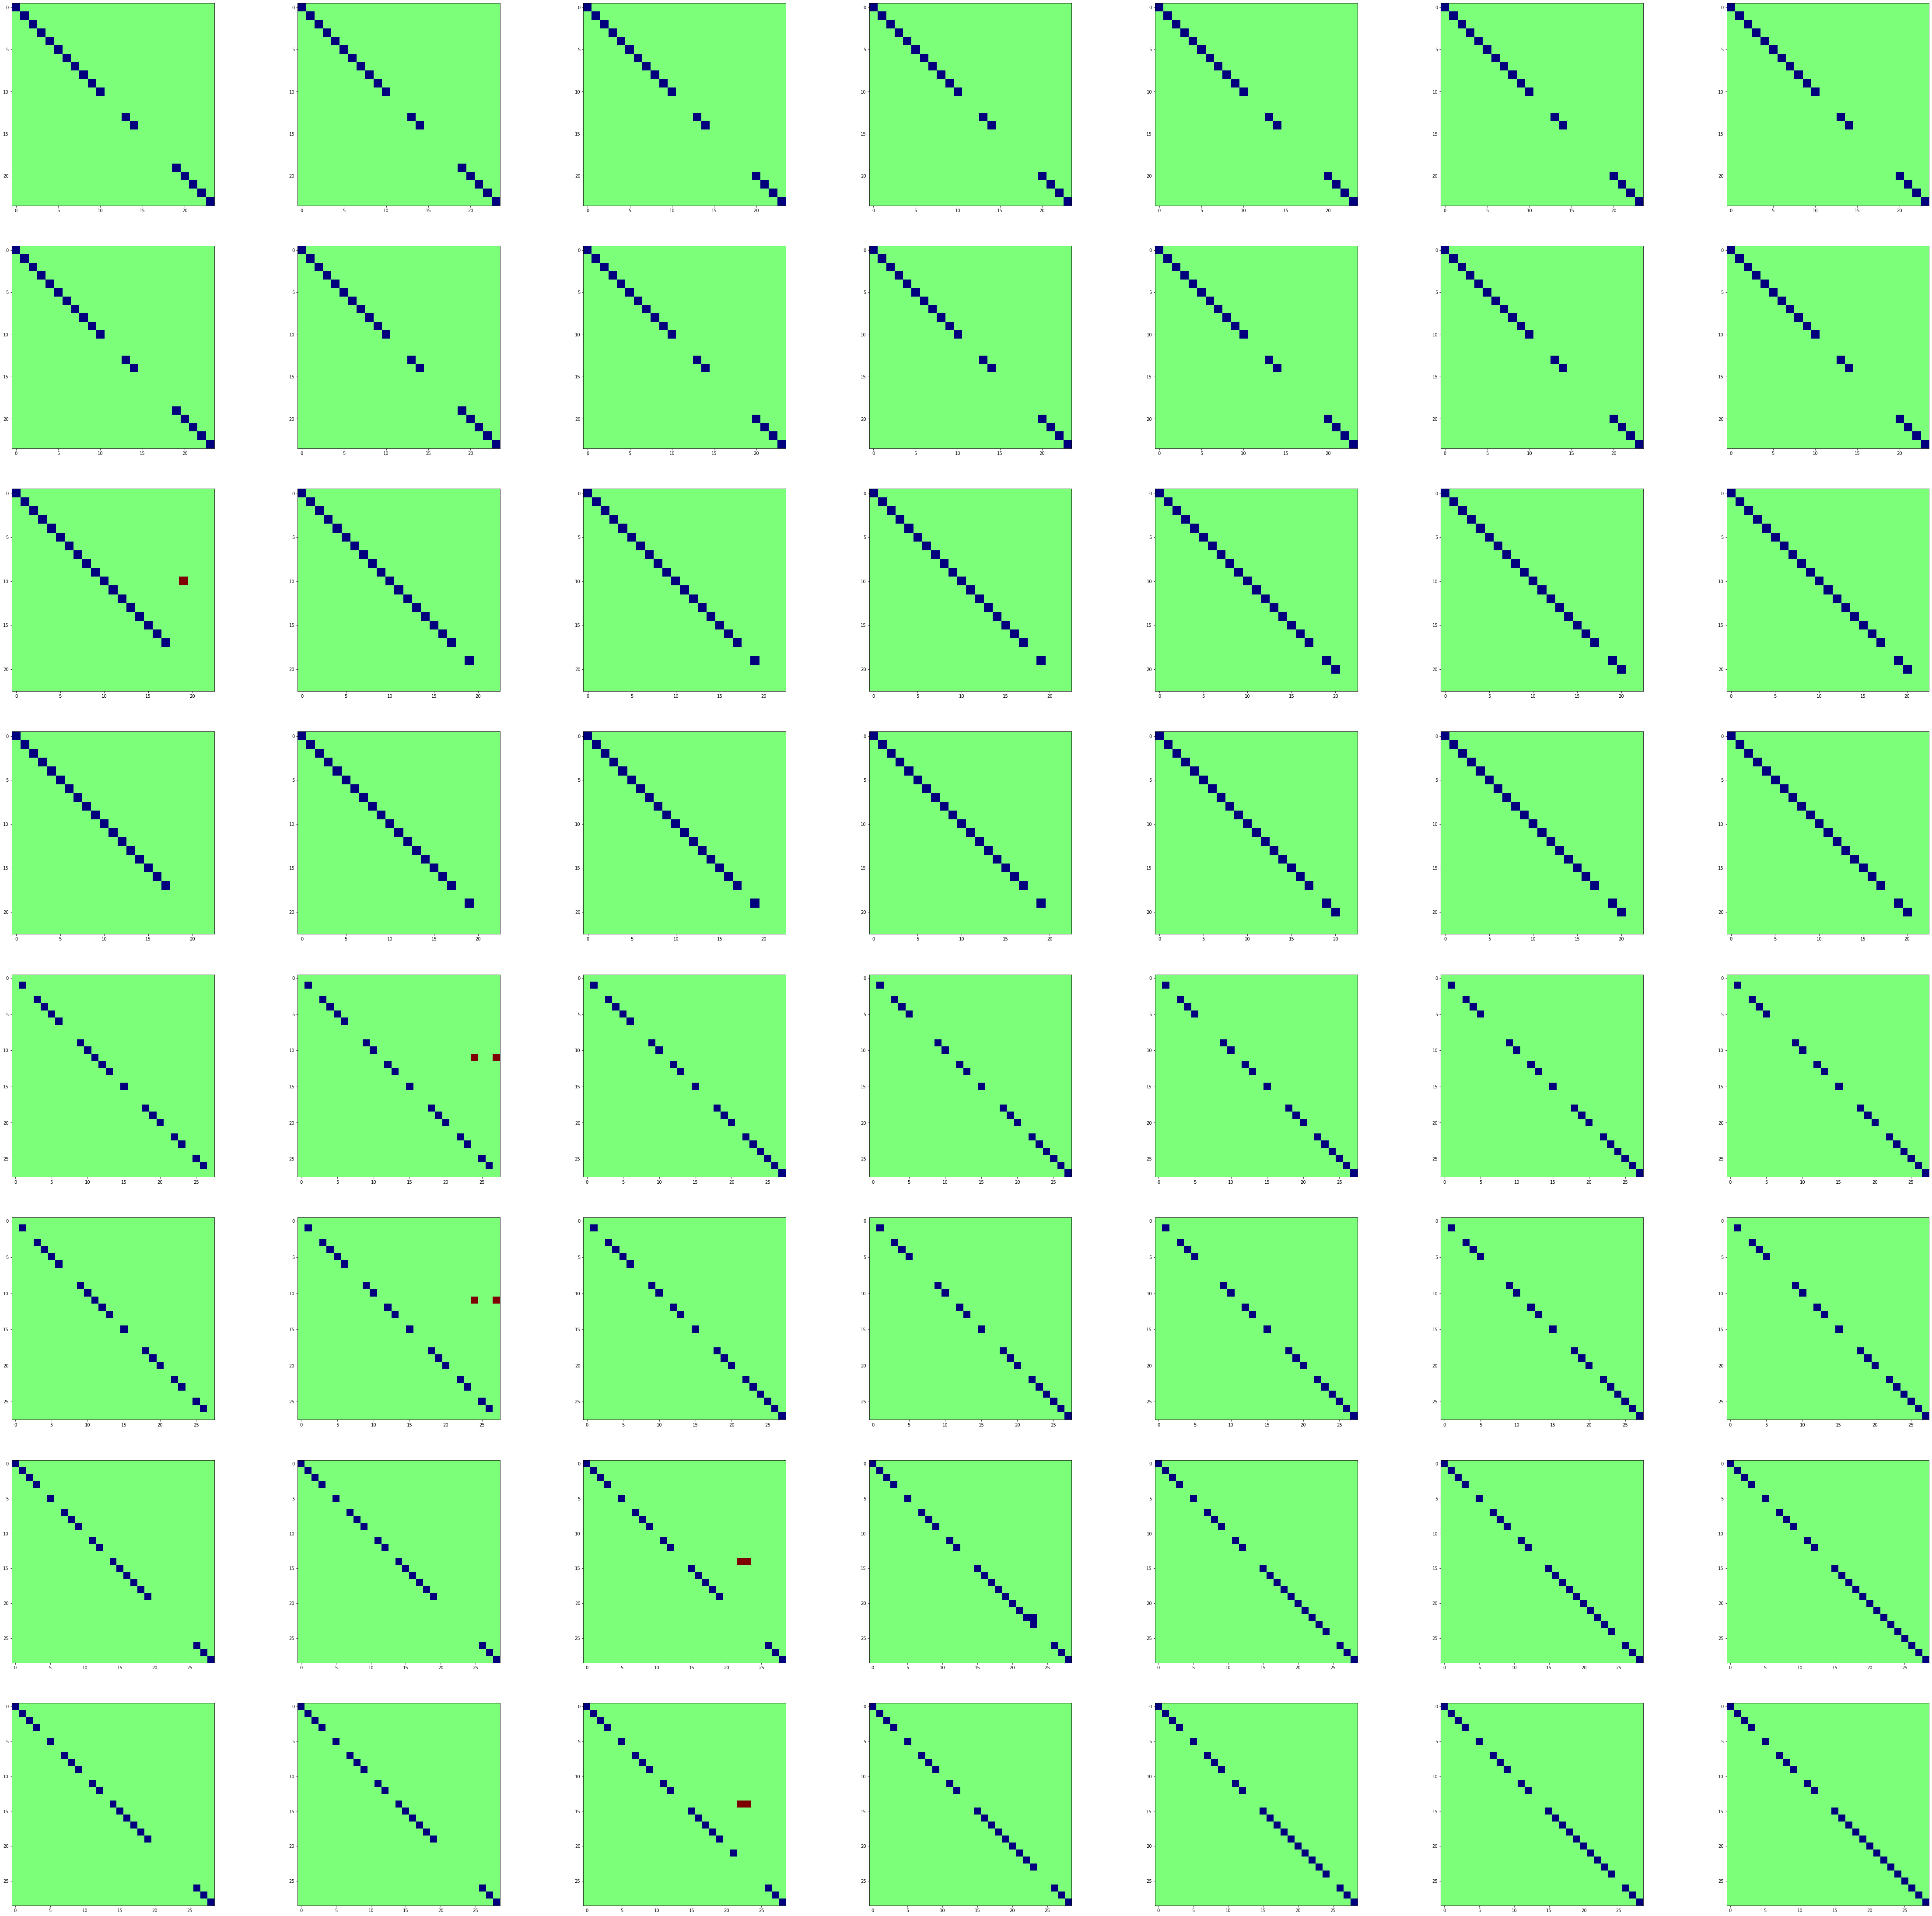

In [14]:
from matplotlib import pyplot as plt

it = val_data.as_numpy_iterator()
x_temp, y_temp = it.next()

temp_adj = y_temp['temporal_adj_matrices']

output = tm.training_model.predict(x_temp)

fig, axes = plt.subplots(8, 7, figsize=(80, 80))

for j in range(4):
    for i in range(7):
        pred = output[j, i, ...]
        truth = temp_adj[j, i, ...]

        summed = np.sum(truth, axis=-1)
        bad_loc = np.where(summed == -3)[1]
        end = bad_loc[0] - 1
        summed = np.sum(truth, axis=-1)

        axes[2 * j, i].imshow(
            np.argmax(pred[0:end, 0:end, :], axis=-1),
            cmap='jet', vmin=0, vmax=2)
        axes[2 * j + 1, i].imshow(
            np.argmax(truth[0:end, 0:end, :]==1, axis=-1),
            cmap='jet', vmin=0, vmax=2)

## Save the Model

In [15]:
# Save models for prediction
inf_path = os.path.join(MODEL_DIR, 'TrackingModelInf')
ne_path = os.path.join(MODEL_DIR, 'TrackingModelNE')

tm.inference_model.save(inf_path)
tm.neighborhood_encoder.save(ne_path)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /data/models/TrackingModelInf/assets


INFO:tensorflow:Assets written to: /data/models/TrackingModelInf/assets


INFO:tensorflow:Assets written to: /data/models/TrackingModelNE/assets


INFO:tensorflow:Assets written to: /data/models/TrackingModelNE/assets


## Next Steps

This model is used within an assignment problem framework to track cells through time-lapse sequences and build cell lineages. To see how this works on example data, see below. 

To use existing models for tracking (and segmentation), refer to its counterpart in the `deepcell.application` [notebook series](https://github.com/vanvalenlab/deepcell-tf/blob/master/notebooks/applications/Nuclear-Application.ipynb).

## Load the Model and Track One Movie

In [16]:
# Instantiate Models
from deepcell.model_zoo.tracking import GNNTrackingModel
tm = GNNTrackingModel()

# Load models for prediction
# (update `ne_path` and `inf_path` if different from above)
tm.neighborhood_encoder = tf.keras.models.load_model(ne_path)
tm.inference_model = tf.keras.models.load_model(inf_path)

Load a segmented movie from `deepcell.datasets` to track

In [17]:
# Choose and load a dataset to track using the trained model
benchmark_filename = 'HEK293_benchmarks.trks'
(X_train, y_train), (X_test, y_test) = deepcell.datasets.tracked.hek293_bench.load_tracked_data(benchmark_filename)
print('HEK293 -\nX.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

path_bench_trks = os.path.join(DATA_DIR, benchmark_filename)
test_data = load_trks(path_bench_trks)

benchmark_index = 1  # this one has divisions

raw_images = test_data['X'][benchmark_index]
labeled_movie = test_data['y'][benchmark_index]

HEK293 -
X.shape: (20, 30, 135, 160, 1)
y.shape: (20, 30, 135, 160, 1)


### Import the cell tracking algorithm and track the movie

In [18]:
from deepcell_tracking import CellTracker

cell_tracker = CellTracker(
    movie=raw_images,
    annotation=labeled_movie,
    track_length=track_length,
    neighborhood_encoder=tm.neighborhood_encoder,
    tracking_model=tm.inference_model)

In [19]:
%%time

cell_tracker.track_cells()

CPU times: user 4.02 s, sys: 137 ms, total: 4.15 s
Wall time: 3.66 s


### Review the results

In [20]:
# View tracked results of each batch as a video
# NB: This does not render well on GitHub
from IPython.display import HTML
from deepcell.utils.plot_utils import get_js_video

# Raw
HTML(get_js_video(np.expand_dims(raw_images, axis=0),
                  batch=0, cmap='gray'))

In [21]:
# Tracked

# Scale the colors to match the max cell label
HTML(get_js_video(np.expand_dims(cell_tracker.y_tracked, axis=0),
                  batch=0, cmap='cubehelix', vmin=0,
                  vmax=len(cell_tracker.tracks)))

# Save the Output

If desired, save the results in our compressed format (.trk - with lineage information), as a movie (.gif - images only/no lineage information), or both

In [22]:
# Save trk file
res_file_path = os.path.join(OUTPUT_DIR, 'hek_test.trk')
cell_tracker.dump(res_file_path)

Optionally, save the output as `.tif` files or `.gif` files for easy inspection.

In [23]:
import imageio

vmax = len(cell_tracker.y_tracked)

raw = []
tracked = []

for i in range(cell_tracker.X.shape[0]):
    new_image = cell_tracker.X[i, ..., 0]
    raw_path = os.path.join(OUTPUT_DIR, 'image_%d.tiff' % i)
    imageio.imwrite(raw_path, new_image.astype('uint8'))
    raw.append(new_image.astype('uint8'))

    label_image = cell_tracker.y_tracked[i, ..., 0].astype('uint8')
    label_path = os.path.join(OUTPUT_DIR, 'label_%d.tiff' % i)
    plt.imsave(label_path, label_image,
               cmap='cubehelix', vmin=0, vmax=vmax)
    # imageio.imwrite(label_path, label_image,
    #                 cmap='cubehelix', vmin=0, vmax=vmax)
    tracked.append(label_image.astype('uint8'))

# Make gifs
imageio.mimsave(os.path.join(OUTPUT_DIR, 'raw.gif'), raw)
imageio.mimsave(os.path.join(OUTPUT_DIR, 'tracked.gif'), tracked)

# Benchmark the Results

N.B. Requires the result to be saved to .trk file

In [24]:
# First, we'll need the ground truth to compare against 
# So we select and save a .trk from our set of tracks (.trks)
gt_trk_path = os.path.join(OUTPUT_DIR, 'hek_test_gt.trk')

gt_trk = {
    'X': test_data['X'][benchmark_index],
    'y_tracked': test_data['y'][benchmark_index],
    'tracks': test_data['lineages'][benchmark_index],
}

# TODO: The following is a work around to save .trk file using CellTracker .dump method
gt_tracker = CellTracker(
    movie=raw_images,
    annotation=labeled_movie,
    neighborhood_encoder=tm.neighborhood_encoder,
    tracking_model=tm.inference_model
)
gt_tracker.dump(filename=gt_trk_path, track_review_dict=gt_trk)

In [25]:
import json
from deepcell_tracking.isbi_utils import benchmark_division_performance

results = benchmark_division_performance(gt_trk_path, res_file_path)

print(json.dumps(results, indent=4))

5_9 out degree = 1, daughters mismatch.
{
    "Correct division": 2,
    "Incorrect division": 1,
    "False positive division": 0,
    "False negative division": 0
}
